# PREPROCESAMIENTO DE DATOS
La idea de este notebook es mostrar cómo afecta la manera de redimensionar las imágenes al resultado de la clasificación. Se han evaluado tres maneras diferentes de redimensionar los datos: 

- Crop: Recortando una imagen cuadrada desde las esquinas utilizando la dimensión menor
- FillBoders: La dimensión menor es rellenada replicando bordes a ambos lados
- Resize: Se hace el redimensionamiento tal cual, deformando la imagen para hacerla cuadrada

## Importar todas las utilidades necesarias

In [1]:
from src.loadData import loadPolenData
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt



Using TensorFlow backend.


## Cargar set de datos
A partir del tamaño deseado, el tipo de redimensionamiento y el número de imágenes de test que se obtendrán del dataset, se cargan el conjunto de entrenamiento y de test utilizando el formato Keras

In [2]:
def loadDataset(resizeType, imgSize, nTest, pathDataset, pathOut):
        return loadPolenData(pathDataset, pathOut + resizeType,
                             resizeType, imgSize, nTest)

## Definir el modelo
En esta función se define el modelo que se utilizará para realizar las pruebas

In [3]:
def defineModel(imgSize, nClass):
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, border_mode='same',
                            input_shape=(imgSize, imgSize,3)))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClass))
    model.add(Activation('softmax'))
    
    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

## Entrenar modelo
Esta función es la encargada de entrenar el modelo generado. 
Se utiliza aumento de datos a partir del conjunto de entrenamiento. Además, se utilizan tantos samples como tamaño tiene el conjunto de entrenamiento para cada iteración. El entrenamiento es llevado a cabo por lotes para evitar problemas de computación

In [4]:
def trainModel(model, xTrain, yTrain, xTest, yTest, nEpochs, logPath):
    tb = TensorBoard(
        log_dir=logPath, 
        histogram_freq=0, 
        write_graph=True, 
        write_images=False)
    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        fill_mode ="nearest")  # randomly flip images

    datagen.fit(xTrain)
    hist = model.fit_generator(datagen.flow(xTrain, yTrain, batch_size=32), 
                        samples_per_epoch=xTrain.shape[0], 
                        #samples_per_epoch=750,
                        nb_epoch=nEpochs, 
                        verbose=2,
                        callbacks=[tb],
                        validation_data=(xTest, yTest))
    return hist, model

## Mostrar resultados
Esta función es la encargada de representar el la precisión de clasificación en el conjunto de test por cada iteración

In [5]:
def plotResults(resizeTypes, resultsAcc, resultsLoss):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    plots = []
    plt.figure(num=1, figsize=(20, 20))
    
    for idx in range(len(resizeTypes)):
        x_numCyc = [j for j in range(0, len(resultsAcc[idx]))]
        plt.subplot(211)
        a, = plt.plot(x_numCyc, resultsAcc[idx], colors[idx % 7])
        
        plt.subplot(212)
        a, = plt.plot(x_numCyc, resultsLoss[idx], colors[idx % 7])
        plots.append(a)
        
    plt.subplot(211)
    plt.legend(plots, resizeTypes)
    plt.xlabel("Ciclo")
    plt.ylabel("val_acc")
    plt.title("VAL_ACC")
    
    plt.subplot(212)
    plt.legend(plots, resizeTypes)
    plt.xlabel("Ciclo")
    plt.ylabel("val_loss")
    plt.title("VAL_LOSS")
    
    plt.show()

## Ejecutar pruebas
Se redimensionan las imágenes a 100x100. Para el conjunto de test se toman 5 imágenes de cada clase. El número de iteraciones utilizado es 300, aunque como se podrá comprobar, el mejor modelo no es obtenido en esta iteración sino en anteriores. 

CROP
___________
Epoch 1/300
10s - loss: 3.2078 - acc: 0.0573 - val_loss: 2.9133 - val_acc: 0.0957
Epoch 2/300
5s - loss: 2.9706 - acc: 0.0846 - val_loss: 2.8069 - val_acc: 0.1478
Epoch 3/300
6s - loss: 2.7981 - acc: 0.1181 - val_loss: 2.6930 - val_acc: 0.2609
Epoch 4/300
6s - loss: 2.7132 - acc: 0.1829 - val_loss: 2.4569 - val_acc: 0.2087
Epoch 5/300
6s - loss: 2.5049 - acc: 0.1959 - val_loss: 2.2943 - val_acc: 0.2522
Epoch 6/300
6s - loss: 2.3876 - acc: 0.2280 - val_loss: 1.9337 - val_acc: 0.3043
Epoch 7/300
6s - loss: 2.2575 - acc: 0.2730 - val_loss: 1.9121 - val_acc: 0.3826
Epoch 8/300
5s - loss: 2.1954 - acc: 0.2833 - val_loss: 1.8710 - val_acc: 0.3826
Epoch 9/300
5s - loss: 2.0813 - acc: 0.3188 - val_loss: 1.8723 - val_acc: 0.3130
Epoch 10/300
5s - loss: 1.9523 - acc: 0.3659 - val_loss: 1.6523 - val_acc: 0.4609
Epoch 11/300
5s - loss: 1.8778 - acc: 0.3782 - val_loss: 1.4904 - val_acc: 0.5130
Epoch 12/300
5s - loss: 1.7208 - acc: 0.4294 - val_loss: 2.2156 - val_acc: 0.3130
Epoch 1

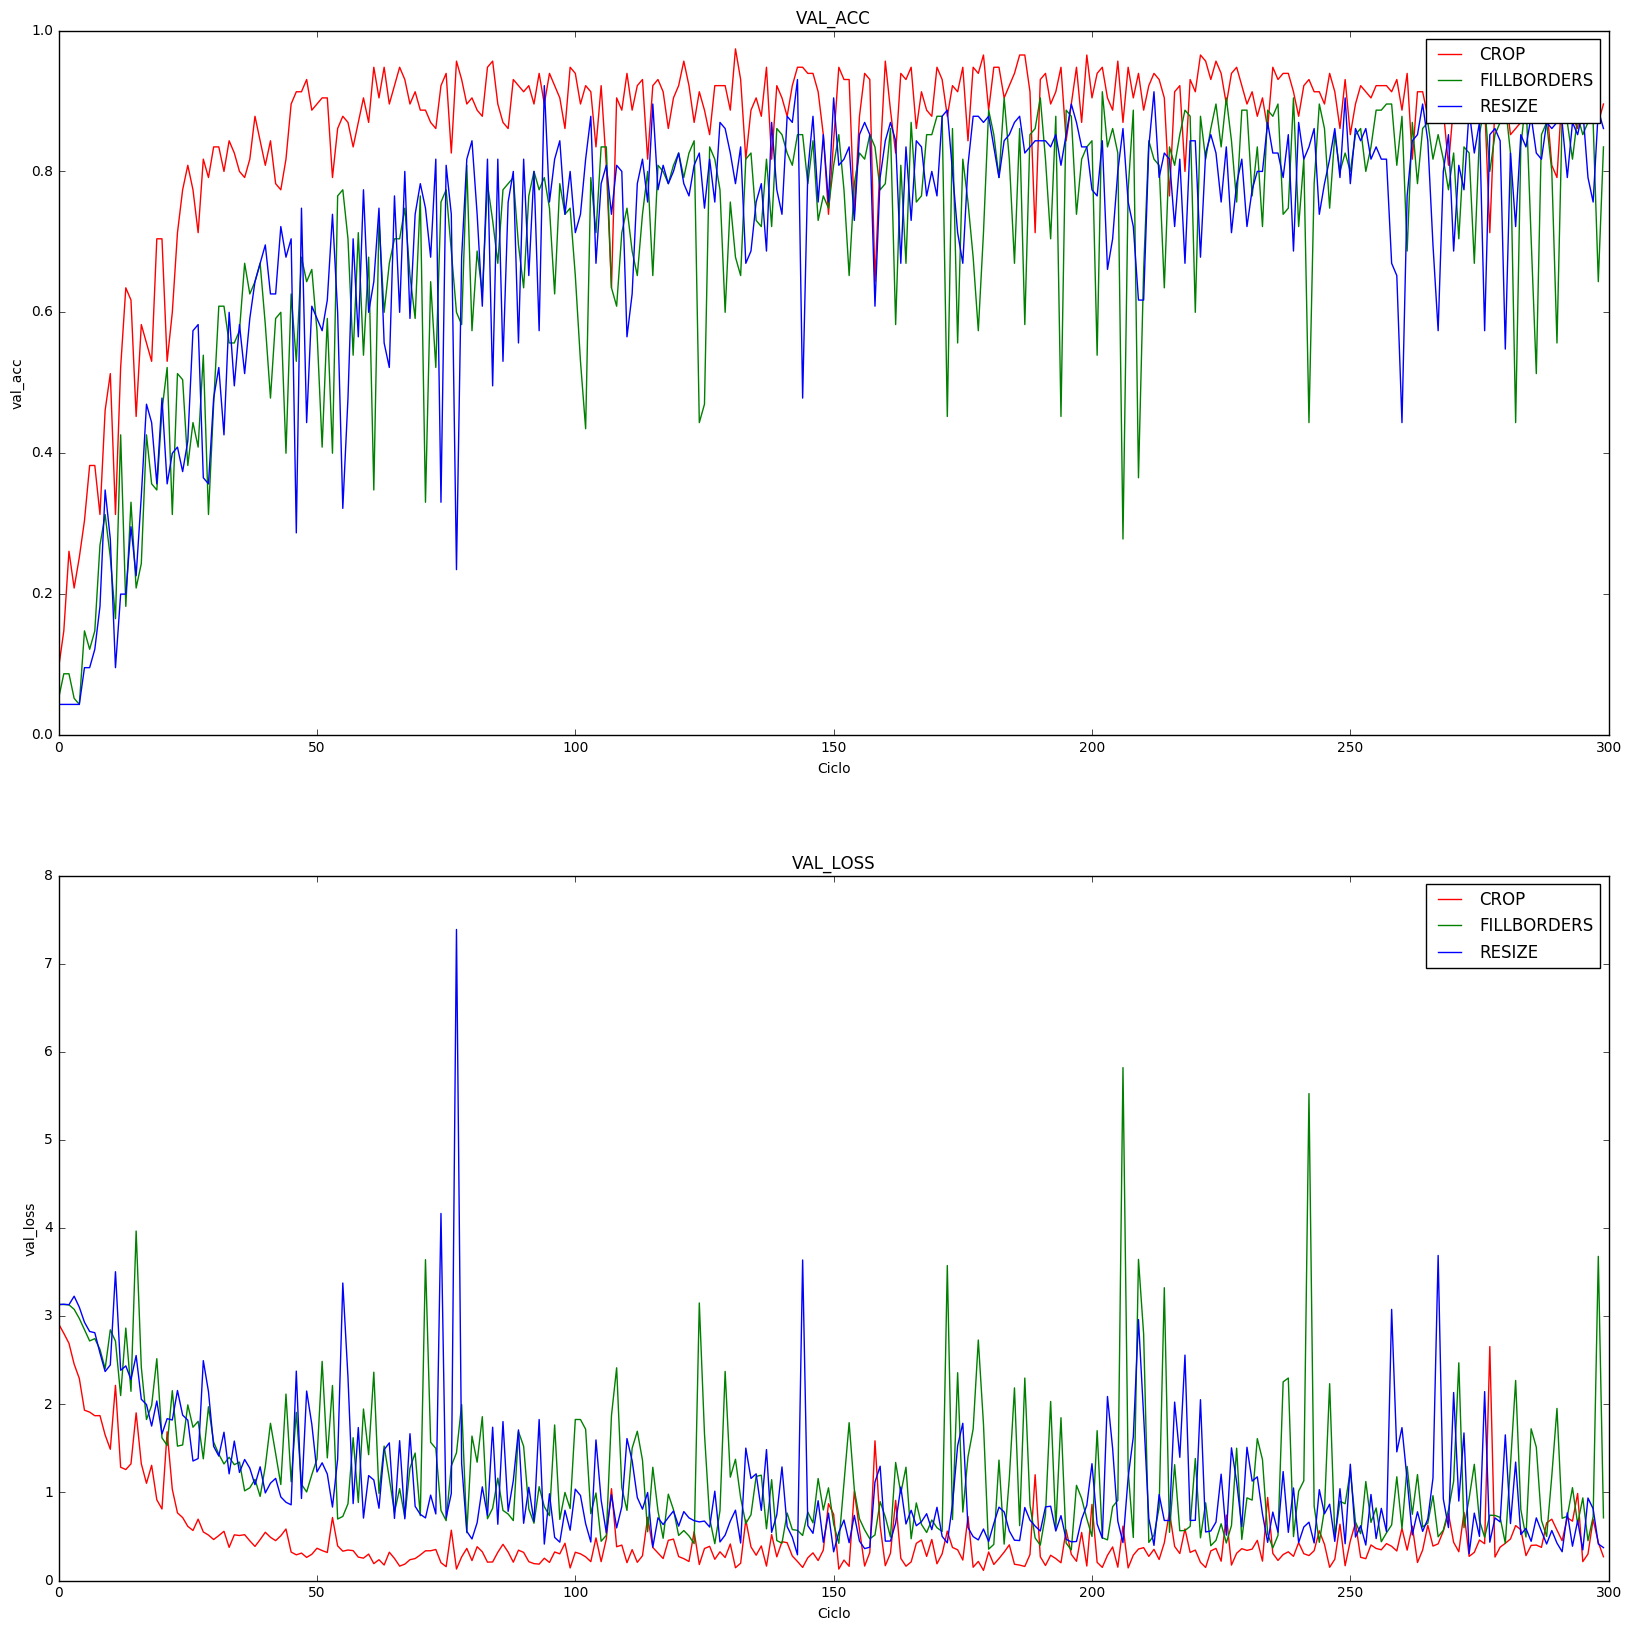

In [6]:
resizeTypes = ["CROP","FILLBORDERS",   "RESIZE"]
nClass = 23
imgSize = 100
nTest = 5
nEpochs = 300

logPath = "./logs"
pathDataset = "./dataset"
pathOut = "./dataset_"

resultsAcc = []
resultsLoss = []

for resizeType in resizeTypes:
    K.clear_session()
    print(resizeType)
    print("___________")
    (xTrain, yTrain), (xTest, yTest) = loadDataset(resizeType, imgSize, nTest, pathDataset, pathOut)
    model = defineModel(imgSize, nClass)
    hist, model = trainModel(model, xTrain, yTrain, xTest, yTest,nEpochs ,logPath)
    resultsAcc.append(hist.history["val_acc"])
    resultsLoss.append(hist.history["val_loss"])
    
    score, acc = model.evaluate(xTest, yTest, batch_size=32)
    print('Test score:', score)
    print('Test accuracy:', acc)
    
    model = None
    
plotResults(resizeTypes, resultsAcc, resultsLoss)

## Resultados
Se puede observar como con esta configuración, el mejor resultado obtenido es el realizado utilizando el redimensionamiento "Crop", es decir, tomando una imagen cuadrada a partir de la dimensión menor. La precisión de clasificación en el conjunto de test en el mejor de los casos está en torno al 95%. 
 